### Sample Imports

In [1]:
from gpflow.ci_utils import ci_niter
from scipy.cluster.vq import kmeans2

iterations = ci_niter(100)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gpflow
from gpflow.utilities import print_summary
from gpflow.config import default_float
import sys
import os
from sklearn.model_selection import train_test_split
import sklearn.metrics
import scipy.stats

sys.path.append('../../Utils')
from metrics import compute_metrics

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, '../../../Data/')

RNA_PROT_EMBED = data_dir+'ProcessedData/protein_embeddings/rna_protein_u64embeddings.pkl'
tf.keras.backend.set_floatx('float64')
#gpflow.config.set_default_float('float32')

In [3]:
device = 0
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[device], 'GPU')

print(f'TF eager exectution: {tf.executing_eagerly()}')
print(f'Using device {physical_devices[device]}')

TF eager exectution: True
Using device PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
class General_MLP(keras.Model):
    def __init__(self,hidden_nodes,input_shape,activation='relu',last=False):
        '''
        https://www.tensorflow.org/api_docs/python/tf/keras/Model
        hidden nodes (array like) - all the dimensions after input including output size
        input shape is optional (tuple), if not specified then network takes input shape as the shape of the first vector passed to it.
        activation (string), type of activation function to use, must be in keras activations
        last (Bool), whether or not to have activation on the final output layer
        ex:
        atlas_mlp = General_MLP([66,1],input_shape=(1,66))
        atlas_mlp.summary()
        '''
        super(General_MLP, self).__init__()
        self.mlp_layers = []
        for nodes in hidden_nodes[0:-1]: 
            self.mlp_layers.append(keras.layers.Dense(nodes, activation=activation))
            
        if last:
            self.mlp_layers.append(keras.layers.Dense(hidden_nodes[-1], activation=activation))
        else:
            self.mlp_layers.append(keras.layers.Dense(hidden_nodes[-1]))
            
        #Specific line is to cast the output to the gpflow default precision
        self.mlp_layers.append(tf.keras.layers.Lambda(lambda x: tf.cast(x, default_float())))
        self.out_size = hidden_nodes[-1]
        
        if type(input_shape) != type(None):
            self.in_size = input_shape[1]
            self.build(input_shape)
    
    #training flag if specific layers behave differently (ex: batch norm), for mlp no difference
    def call(self, inputs, training=True):
        for layer in self.mlp_layers:
            inputs = layer(inputs)
        return inputs

In [5]:
class nn_based_kernel(gpflow.kernels.Kernel):
    def __init__(self,base_kernel: gpflow.kernels.Kernel,nn_model):
        super(nn_based_kernel, self).__init__()
        assert(nn_model.built),"NN model is not built, input shape is not initialized"

        self.cnn = nn_model
        self.base_kernel = base_kernel
    
    def K(self,X,X2=None,presliced=False):
        """
        If you add a method in the child class with the same name as a function in the
        parent class, the inheritance of the parent method will be overridden.
        """
        transformed_X = self.cnn(X)
        transformed_X2 = self.cnn(X2) if X2 is not None else X2
        return self.base_kernel.K(transformed_X, transformed_X2, presliced)
    
    def K_diag(self, X_input,presliced=False):
        transformed_X = self.cnn(X_input)
        return self.base_kernel.K_diag(transformed_X, presliced)

In [6]:
with open(RNA_PROT_EMBED,'rb') as file:
    rna_prot_embed = pickle.load(file)

In [7]:
#Code Parameters
#-----------------------------------------
cols_drop=['ProteinAUC']
MRNA_THRESH = 0
ZSCORE = True
BATCH = 32
SAVE = False
LOG_TRANS = True
#-----------------------------------------

data = rna_prot_embed['AM_04M_F0'].copy()
data.drop(columns='AvgChrs',inplace=True)
data = data[data['mRNA_TMM']>MRNA_THRESH]

if LOG_TRANS:
    #Log transform mRNA, protein, and protein length -> log-normal distributed
    data['mRNA_TMM'] = np.log2(data['mRNA_TMM']+1)
    data['ProteinAUC'] = np.log2(data['ProteinAUC']+1)
    data['ProteinLength'] = np.log2(data['ProteinLength']+1)

SEED = 10
train,test = train_test_split(data,test_size=0.2,random_state=SEED)
SEED = 42
train,val = train_test_split(train,test_size=0.2,random_state=SEED)
train.head()

,,,mRNA_TMM,ProteinAUC,ProteinLength,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
Gene.names,Majority.protein.IDs,cell,,,,,,,,,,,,,,,,,,,,,
Rps3,P62908,AM_04M_F0,9.399098,26.761112,7.930737,-0.085505,0.144599,-0.125936,-0.968383,-0.031190,-0.106168,0.075443,...,0.121134,0.006451,-0.033684,-0.082530,-0.017069,0.428129,-0.164145,-0.043922,0.412728,-0.001903
Ccdc22,Q9JIG7,AM_04M_F0,2.643520,24.745706,9.294621,0.052259,0.160503,-0.115460,-0.990235,-0.097925,-0.065146,0.048975,...,0.105971,0.028436,0.115947,-0.092702,0.033482,0.436445,-0.139643,-0.013778,0.242822,0.065144
Ylpm1,Q9R0I7,AM_04M_F0,6.317038,23.069644,10.437752,0.036306,0.083100,-0.155466,-0.982812,-0.137777,-0.457483,-0.054906,...,0.211440,0.216405,0.184683,-0.124725,0.029601,0.354003,-0.310361,-0.033418,0.250332,-0.054125
Gnai3,Q9DC51,AM_04M_F0,7.808586,25.292660,8.471675,-0.123134,0.126303,-0.092475,-0.969833,-0.005820,-0.057672,0.107903,...,0.137047,0.008167,-0.088351,-0.018563,-0.036717,0.443771,-0.123508,-0.036990,0.424119,0.014253
Cct8,P42932,AM_04M_F0,7.393539,25.531755,9.100662,-0.071893,0.114264,-0.134181,-0.938758,-0.009126,-0.115529,0.090082,...,0.084978,0.013348,-0.042802,-0.086967,0.016824,0.263484,-0.154519,-0.040509,0.377616,-0.035322


In [8]:
def zscore(train_df):
    assert isinstance(train_df,pd.DataFrame)
    means = train_df.mean(axis=0)
    stds = train_df.std(axis=0)
    zscored = (train_df-means)/stds
    return zscored, means, stds

if ZSCORE:
    print(f'Data is z-scored')
    train, train_mean, train_std = zscore(train) #zscore data
    val = (val-train_mean)/train_std #zscore validation data using mean and std from train set
    test = (test-train_mean)/train_std #zscore test data using mean and std from train set

Data is z-scored


In [9]:
x_train = train.drop(columns=cols_drop).values
y_train = train[['ProteinAUC']].values
total_num_data = x_train.shape[0]

x_val = val.drop(columns=cols_drop).values
y_val = val[['ProteinAUC']].values

x_test = test.drop(columns=cols_drop).values
y_test = test[['ProteinAUC']].values

print(f'train dataset size: {x_train.shape}')
print(f'validation dataset size: {x_val.shape}')
print(f'test dataset size: {x_test.shape}')

trn_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
trn_dataset = trn_dataset.shuffle(buffer_size=x_train.shape[0]).batch(BATCH) #I think default is 32

val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_dataset = val_dataset.batch(BATCH)

train dataset size: (2287, 66)
validation dataset size: (572, 66)
test dataset size: (715, 66)


In [10]:
class KernelSpaceInducingPoints(gpflow.inducing_variables.InducingPoints):
    pass

@gpflow.covariances.Kuu.register(KernelSpaceInducingPoints, nn_based_kernel)
def Kuu(inducing_variable, kernel, jitter=None):
    func = gpflow.covariances.Kuu.dispatch(gpflow.inducing_variables.InducingPoints, gpflow.kernels.Kernel)
    return func(inducing_variable, kernel.base_kernel, jitter=jitter)

@gpflow.covariances.Kuf.register(KernelSpaceInducingPoints, nn_based_kernel, object)
def Kuf(inducing_variable, kernel, a_input):
    return kernel.base_kernel(inducing_variable.Z, kernel.cnn(a_input))

In [11]:
manifold_mlp = General_MLP([64,4],input_shape=(1,66),last=True)
manifold_mlp.summary()

Model: "general_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2144      
_________________________________________________________________
dense_1 (Dense)              multiple                  132       
_________________________________________________________________
lambda (Lambda)              multiple                  0         
Total params: 2,276
Trainable params: 2,276
Non-trainable params: 0
_________________________________________________________________


In [12]:
base_kernel = gpflow.kernels.SquaredExponential(lengthscale=[1]*manifold_mlp.out_size) #Initialize ARD for lengthscale
kernel = nn_based_kernel(base_kernel,manifold_mlp)
#print_summary(kernel)

In [13]:
num_inducing_points = 100
gene_subset, labels_subset = next(iter(trn_dataset.batch(32)))
gene_size = tf.reduce_prod(gene_subset[0,0,:].shape)
gene_subset = tf.reshape(gene_subset, [-1, gene_size])
labels_subset = tf.reshape(labels_subset, [-1, 1])

In [14]:
inducing_variable_kmeans = kmeans2(gene_subset.numpy(), num_inducing_points, minit='points')[0]
inducing_variable_cnn = kernel.cnn(inducing_variable_kmeans)
inducing_variable = KernelSpaceInducingPoints(inducing_variable_cnn)

In [15]:
likelihood = gpflow.likelihoods.Gaussian()

In [16]:
model = gpflow.models.SVGP(kernel, likelihood,
                           inducing_variable=inducing_variable,
                           num_data=total_num_data)
#print_summary(model)

In [17]:
#optimizer = tf.keras.optimizers.RMSprop(0.001)
#optimizer = tf.keras.optimizers.SGD(0.001) #-> need lr, momentum, neustrov?
optimizer = tf.keras.optimizers.Adam() #default 0.001
avg_elbo = tf.keras.metrics.Mean()
val_avg_elbo = tf.keras.metrics.Mean()

In [25]:
EPOCHS = 150
train_elbo = []
val_elbo = []

for epoch in range(EPOCHS):
    for step, (x_batch_train,y_batch_train) in enumerate(trn_dataset): #iterate over batches of the dataset
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(model.trainable_variables)
            obj = -model.elbo((x_batch_train,y_batch_train))
            grads = tape.gradient(obj, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        #average elbo over batches
        avg_elbo(obj)
        
    #Validation elbo
    for (x_batch_val,y_batch_val) in val_dataset:
        obj_val = -model.elbo((x_batch_val,y_batch_val))
        val_avg_elbo(obj_val)
        
    if epoch>=1 and epoch % 5 == 0 or epoch == 1:
        print(f'Epoch {epoch}, avg Tbatch elbo {avg_elbo.result()} improvement {train_elbo[-1]-avg_elbo.result()}, avg Vbatch elbo {val_avg_elbo.result()}')
    
    train_elbo.append(avg_elbo.result())
    val_elbo.append(val_avg_elbo.result())
    
    #Reset mean
    avg_elbo.reset_states()
    val_avg_elbo.reset_states()

Epoch 1, avg Tbatch elbo 1646.8593222186419 improvement -23.948973850795255, avg Vbatch elbo 4401.885435083117
Epoch 5, avg Tbatch elbo 1665.2040787955034 improvement -21.262546923788022, avg Vbatch elbo 4072.6198037800746
Epoch 10, avg Tbatch elbo 1650.6736875111355 improvement -48.33995997254033, avg Vbatch elbo 4344.367888446461
Epoch 15, avg Tbatch elbo 1629.9166271647855 improvement -22.70120241991276, avg Vbatch elbo 4322.297626271402
Epoch 20, avg Tbatch elbo 1570.6738780879723 improvement 15.574993100103256, avg Vbatch elbo 4672.9980137209195
Epoch 25, avg Tbatch elbo 1575.7983605025618 improvement 20.62289320162654, avg Vbatch elbo 4512.181490727279
Epoch 30, avg Tbatch elbo 1597.4450209597012 improvement -33.26898353082629, avg Vbatch elbo 4699.22436722121
Epoch 35, avg Tbatch elbo 1548.447901193464 improvement 44.05598752857145, avg Vbatch elbo 4369.363002833005
Epoch 40, avg Tbatch elbo 1523.4030553352557 improvement 55.828822362496794, avg Vbatch elbo 4716.376714888
Epoch 

In [31]:
model.trainable_variables

(<tf.Variable 'Variable:0' shape=(100, 4) dtype=float64, numpy=
 array([[ 1.47977193e+00, -1.05389494e-01,  2.06564266e-01,
          8.24582831e-01],
        [ 1.86078408e+00,  1.59248013e-03, -2.67047037e-02,
          1.05958972e+00],
        [-2.05269237e-02,  1.33909876e-02, -1.14739308e-01,
         -1.98713903e-02],
        [ 1.92276687e+00,  4.85367864e-02, -5.15059617e-02,
          2.01362366e+00],
        [ 5.69817657e-01, -1.09194741e-01,  7.40788259e-01,
          1.72246445e+00],
        [ 1.17197632e+00,  2.35342250e-01,  2.14365730e+00,
          1.93793125e+00],
        [ 1.07529033e+00,  8.74274589e-02,  1.01155511e-03,
          7.52547747e-01],
        [-2.45525177e-01,  2.12098292e-01,  4.80945245e-01,
          1.70511873e+00],
        [ 6.86480012e-01,  1.07925242e-01,  5.68228982e-01,
          4.70620452e-02],
        [ 6.58483132e-02, -9.37707775e-02,  5.18829507e-02,
         -3.90496576e-01],
        [ 9.95588544e-01, -3.02753497e-02,  1.33283824e-01,
      

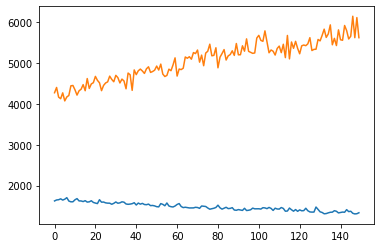

In [26]:
plt.plot(train_elbo)
plt.plot(val_elbo)

In [27]:
mean, var = model.predict_f(x_train)
metrics = compute_metrics(mean.numpy(), y_train, y_train, fc_scale=2)
metrics

{'mae': 0.3354906418282698,
 'mse': 0.19103818459700608,
 'smse': 0.1911217533566724,
 'r2': 0.8088782466433276,
 'evs': 0.8089906822461678,
 'spearmanrho': 0.8747115819045285,
 'spearmanrho_p': 0.0,
 'pearsonr': 0.9032551718770488,
 'pearsonr_p': 0.0,
 'median_abs_fc': 1.2004342035242705,
 'mean_abs_fc': 1.2618064598431988}

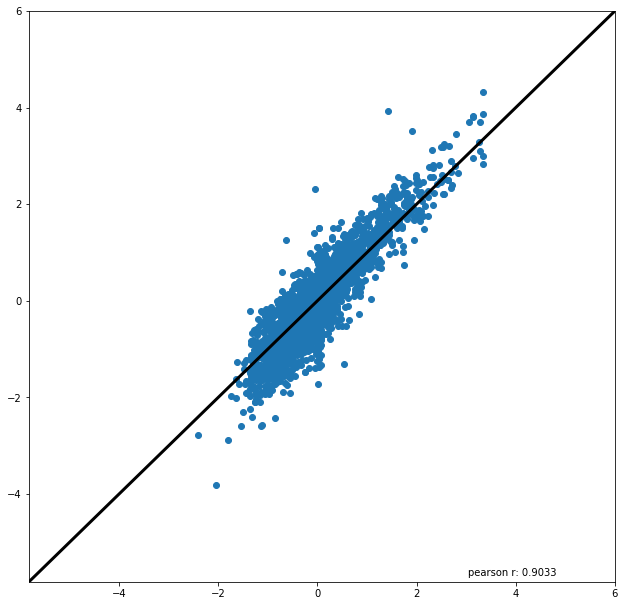

In [28]:
fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)

ax.scatter(mean.numpy(),y_train)
y_max = int(y_train.max())+2
y_min = y_train.min()-2
ax.set_xlim(y_min,y_max)
ax.set_ylim(y_min,y_max)

x = np.linspace(*ax.get_xlim())
# ax.plot([0,1],[0,1], transform=ax.transAxes)
ax.plot(x, x,color='k',linewidth=3)

pearson = scipy.stats.pearsonr(y_train.squeeze(),mean.numpy().squeeze())[0]
ax.text(.75,.01,f'pearson r: {pearson:.4f}',transform=ax.transAxes)
if SAVE:
    fig.savefig(f"./results/am04f0/test_predicted_{TITLE}.pdf")

In [29]:
## predict mean and variance of latent GP at test points
mean, var = model.predict_f(x_test)
metrics = compute_metrics(mean.numpy(), y_test, y_train, fc_scale=2)

# if SAVE:
#     pd.DataFrame.from_dict(metrics,orient='index').T.to_csv(f'./results/am04f0/metrics_{TITLE}.tsv',sep='\t')

metrics

{'mae': 0.6889261850689691,
 'mse': 0.7971096033111195,
 'smse': 0.7754343514248854,
 'r2': 0.22438524448016794,
 'evs': 0.23460864998763198,
 'spearmanrho': 0.5552893222913731,
 'spearmanrho_p': 4.463856502715384e-59,
 'pearsonr': 0.5948189589948767,
 'pearsonr_p': 1.2395845209911797e-69,
 'median_abs_fc': 1.4483541164529137,
 'mean_abs_fc': 1.6120831792665349}

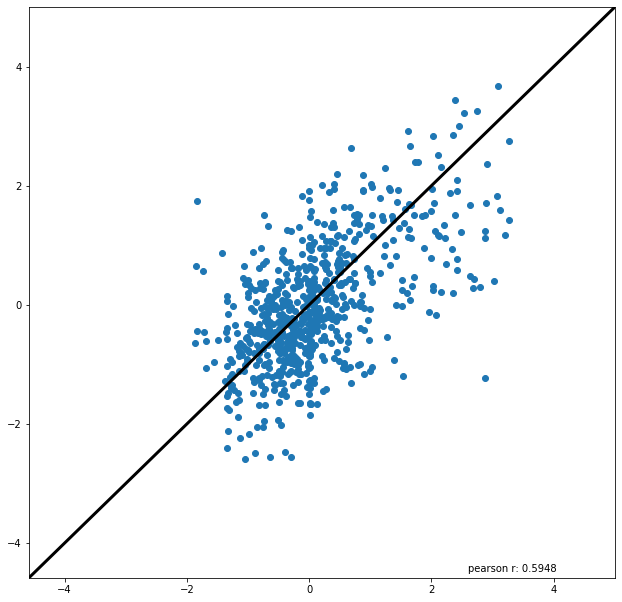

In [30]:
fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)

ax.scatter(mean.numpy(),y_test)
y_max = int(y_test.max())+2
y_min = y_test.min()-2
ax.set_xlim(y_min,y_max)
ax.set_ylim(y_min,y_max)

x = np.linspace(*ax.get_xlim())
# ax.plot([0,1],[0,1], transform=ax.transAxes)
ax.plot(x, x,color='k',linewidth=3)

pearson = scipy.stats.pearsonr(y_test.squeeze(),mean.numpy().squeeze())[0]
ax.text(.75,.01,f'pearson r: {pearson:.4f}',transform=ax.transAxes)
if SAVE:
    fig.savefig(f"./results/am04f0/test_predicted_{TITLE}.pdf")